<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/janmejay-dev/Project_infosys_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship — Sprint 1

**Purpose:** notebook that fetches market & news data, synthesizes/ingests tweet-like text, runs sentiment analysis (FinBERT + lightweight fallback), and visualizes sentiment vs price trends.

**Team Members:**<br>
Anshika Gupta<br>
Gopichand<br>
Janmejay Singh<br>
Vaishnavi<br>

<!-- Colab badge: opens this notebook in Google Colab -->
<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/main/Project_Sprint1.ipynb" target="_blank">
  <img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

**Quick run**
- **In Google Colab**: click the badge above and run the notebook cells in order (or: `Runtime → Run all`).

**Required environment variables / API keys**
- `ALPHA_VANTAGE_API` — Alpha Vantage API key (for market prices).
- Optional: `SLACK_WEBHOOK_URL` — (for Slack alerts).
Set these either as environment variables or (in Colab) via `google.colab.userdata.set()`.

**Notes & warnings**
- The notebook may download large models (e.g., `ProsusAI/finbert`). This can be slow on CPU and will use significant bandwidth and disk space. A GPU runtime is **recommended** for FinBERT inference.


## Project Overview

This notebook is developed as part of the **Infosys Springboard Internship ** and demonstrates a complete **financial sentiment analysis pipeline** using real-world market and news data.

### 🔹 What this notebook does
1. Accepts a **company name** as user input.
2. Fetches:
   - **Stock market data** from Alpha Vantage / Yahoo Finance
   - **News articles** from Google News RSS
   - **Company description** from Wikipedia
3. Collects or generates **tweet-style financial text**.
4. Performs **sentiment analysis** using:
   - ✅ `ProsusAI/finbert` (finance-specific transformer model)
   - ✅ Lightweight NLP fallback (TextBlob)
5. Produces:
   - 📊 Sentiment distribution plots
   - 📈 Price vs sentiment trend analysis
6. Sends **Slack alerts** based on detected sentiment.

---

### 🔹 Key Outputs Generated
- Processed tweet sentiment (`positive`, `neutral`, `negative`)
- Market trend graph
- Sentiment trend visualization
- Slack notification

---

### ⚠️ Reproducibility Notes
- Internet access is required.
- API keys must be configured before execution.
- Some models require high memory and may run slow on CPU-only systems.



In [1]:
# =========================
# USER INPUT (RESTRICTED TO PREDEFINED LIST)
# =========================

ALLOWED_COMPANIES = {
    "NETFLIX",
    "APPLE",
    "TESLA",
    "GOOGLE",
    "MICROSOFT",
    "TCS",
    "INFOSYS",
    "RAKUTEN",
    "BITCOIN",
    "AMAZON",
    "META",
    "NVIDIA",
    "AMD",
    "INTEL",
    "JP MORGAN",
    "GOLDMAN SACHS",
    "MASTERCARD",
    "VISA",
    "RELIANCE",
    "HDFC",
    "ICICI",
    "WIPRO",
    "HCL",
    "ADANIPORTS",
    "ADANIENT",
    "TATA MOTORS",
    "MARUTI",
    "COCA COLA",
    "PEPSICO",
    "WALMART",
    "ETHEREUM",
    "DOGECOIN",
    "SOLANA"
}

def get_valid_company_name():
    """
    Restricts user input strictly to a predefined list of companies.
    Ignores case and extra spaces.

    Returns:
        str: Validated company name
    """

    print("✅ Please select a company ONLY from the list below:\n")
    for name in (ALLOWED_COMPANIES):
        print("•", name)

    print("\n--------------------------------------")

    while True:
        user_input = input("Enter company name exactly as shown above: ").strip().upper()

        # ❌ Empty input
        if not user_input:
            print("❌ Input cannot be empty. Please select from the provided list.")
            continue

        # ❌ Invalid company
        if user_input not in ALLOWED_COMPANIES:
            print("❌ Invalid selection. Please select from the provided list only.")
            continue

        return user_input.title()


# Collect validated input
company_name = get_valid_company_name()

print(f"\n✅ Selected company for analysis: {company_name}")


✅ Please select a company ONLY from the list below:

• INFOSYS
• RAKUTEN
• AMAZON
• SOLANA
• RELIANCE
• MARUTI
• MASTERCARD
• TESLA
• DOGECOIN
• NETFLIX
• ICICI
• PEPSICO
• ADANIENT
• MICROSOFT
• AMD
• HDFC
• HCL
• TCS
• INTEL
• META
• VISA
• NVIDIA
• BITCOIN
• TATA MOTORS
• WIPRO
• GOLDMAN SACHS
• COCA COLA
• APPLE
• ADANIPORTS
• GOOGLE
• JP MORGAN
• WALMART
• ETHEREUM

--------------------------------------
Enter company name exactly as shown above: tcs

✅ Selected company for analysis: Tcs


##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [2]:
# =========================
# SAFE PACKAGE INSTALLATION & VERIFICATION
# =========================

import sys
import subprocess
import importlib

REQUIRED_PACKAGES = [
    "transformers",
    "torch",
    "yfinance",
    "alpha-vantage",
    "textblob",
    "feedparser",
    "beautifulsoup4",
    "faker",
    "pandas",
    "numpy",
    "matplotlib",
    "wikipedia",
    "requests"
]

def install_if_missing(package):
    try:
        importlib.import_module(package.replace("-", "_"))
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"⏳ Installing {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install all required packages
for pkg in REQUIRED_PACKAGES:
    install_if_missing(pkg)

print("\n✅ Package installation complete.")


# 🔥 Hardware & Runtime Warning
try:
    import torch
    if not torch.cuda.is_available():
        print("⚠️ GPU not detected. FinBERT will run slowly on CPU.")
    else:
        print("✅ GPU detected. FinBERT will run efficiently.")
except:
    print("⚠️ Torch not loaded yet. GPU detection skipped.")


✅ transformers already installed
✅ torch already installed
✅ yfinance already installed
⏳ Installing alpha-vantage ...
✅ textblob already installed
⏳ Installing feedparser ...
⏳ Installing beautifulsoup4 ...
⏳ Installing faker ...
✅ pandas already installed
✅ numpy already installed
✅ matplotlib already installed
⏳ Installing wikipedia ...
✅ requests already installed

✅ Package installation complete.
⚠️ GPU not detected. FinBERT will run slowly on CPU.


## 📘 Company Overview Retrieval (Wikipedia)

This section retrieves a **brief public overview of the selected company** using the official Wikipedia API. This provides:

- ✅ Business background
- ✅ Industry context
- ✅ General understanding before data analysis
- ✅ Human-readable description for reports and dashboards  

---

### 🔹 Why this step is important
- Helps users understand **what entity is being analyzed**
- Adds **context to sentiment and market trends**

---

### 🔹 What this cell does
- Queries Wikipedia using the validated `company_name`
- Automatically resolves:
  - Page disambiguation (e.g., multiple meanings of the same name)
  - Missing pages
  - Network failures
- Limits the output to a **short readable summary**

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **never crash the notebook** even if:
- The company page does not exist
- Multiple Wikipedia pages match
- Internet access is unavailable  
In all cases, a meaningful fallback message is returned.

---

### ✅ Output
A short textual description of the selected company or asset that will be displayed to the user before market and sentiment analysis begins.


In [4]:
# =========================
# ROBUST WIKIPEDIA COMPANY OVERVIEW FETCH
# =========================
import warnings
from bs4 import GuessedAtParserWarning

warnings.filterwarnings(
    "ignore",
    category=GuessedAtParserWarning
)

import wikipedia


def _generate_variants(name):
    variants = [
        name,
        f"{name} Inc.",
        f"{name}, Inc.",
        f"{name} Corporation",
        f"{name} Company",
        f"{name} Ltd.",
        f"{name} (company)",
        f"{name} (company)",
        f"{name} (film)",
        f"{name} (cryptocurrency)"
    ]

    seen = set()
    out = []
    for v in variants:
        if v.lower() not in seen:
            seen.add(v.lower())
            out.append(v)
    return out

def fetch_wikipedia_summary(company_name, max_sentences=10):
    """
    Robustly fetch a short Wikipedia summary for a company/asset.
    Tries: direct lookup, wikipedia.search suggestions, common name variants,
    and gracefully handles disambiguation/page/network errors.

    Returns:
        str: Short summary or informative fallback message.
    """
    # 1) Try direct summary first (fast path)
    try:
        return wikipedia.summary(company_name, sentences=max_sentences)
    except wikipedia.exceptions.DisambiguationError as e:
        # Will fall through to search-based resolution below
        pass
    except wikipedia.exceptions.PageError:
        pass
    except Exception:
        # Network or unexpected failure — we'll try search but keep fallback
        pass

    # 2) Try searching for likely titles
    try:
        search_results = wikipedia.search(company_name, results=8)
    except Exception:
        search_results = []

    # 3) If search returned candidates, pick the best (first) candidate and fetch summary
    for candidate in search_results:
        try:
            # Avoid picking obviously irrelevant short matches (like single letters)
            if len(candidate) < 2:
                continue
            summary = wikipedia.summary(candidate, sentences=max_sentences)
            return summary
        except wikipedia.exceptions.DisambiguationError:
            # If candidate is ambiguous, try the first option from its disambiguation
            try:
                dis_opt = wikipedia.search(candidate, results=1)
                if dis_opt:
                    summary = wikipedia.summary(dis_opt[0], sentences=max_sentences)
                    return summary
            except Exception:
                continue
        except Exception:
            continue

    # 4) Try helpful title variants (Inc., Ltd., Corporation, etc.)
    for variant in _generate_variants(company_name):
        try:
            summary = wikipedia.summary(variant, sentences=max_sentences)
            return summary
        except Exception:
            continue

    # 5) Final fallback
    return (f"⚠️ Could not reliably fetch a Wikipedia summary for '{company_name}'. "
            "This may be due to ambiguous names or missing pages. ")

# Usage: get the summary and print it
wiki_summary = fetch_wikipedia_summary(company_name)
print("\n📘 Company Overview (Wikipedia):\n")
print(wiki_summary)



📘 Company Overview (Wikipedia):

Tata Consultancy Services (TCS) is an Indian multinational technology company specializing in information technology services and consulting. Headquartered in Mumbai, it is a part of the Tata Group and operates in 150 locations across 46 countries. As of 2024, Tata Sons owned 71.74% of TCS, and close to 80% of Tata Sons' dividend income came from TCS.
TCS ranked seventh on the Fortune India 500 list for 2024. In September 2021, TCS recorded a market capitalization of US$200 billion, becoming the first Indian IT company to achieve this valuation. In 2012, it was the world's second-largest user of U.S. H-1B visas.


== History ==


=== 1968–2000 ===

Tata Consultancy Services Limited, originally known as Tata Computer Systems, was established in 1968 by Tata Sons Limited. The company's initial contracts involved providing punched card services to its sister company TISCO (now Tata Steel), developing an Inter-Branch Reconciliation System for the Central B

## 📊 Market Data Retrieval (Stocks & Crypto)

This section retrieves **historical price data** for the selected company or cryptocurrency.


### 🔹 What this cell does
- Automatically detects and fetches:
  - **Stock market data** (e.g., Tesla, Apple, Reliance)
  - **Cryptocurrency data** (e.g., Bitcoin, Ethereum)
- Uses **Yahoo Finance (`yfinance`)** as the primary data source
- Fetches:
  - Daily closing prices
  - Date-wise time-series data for the last few months

---

### 🔹 Why this step is important
- Provides the **numerical basis** for:
  - Trend analysis
  - Graph plotting
  - Market movement interpretation

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **fail safely without stopping the notebook** if:
- The ticker symbol is invalid
- Internet connection is unavailable
- The API does not return data
- The selected asset is delisted or inactive

In such cases:
- A warning message is printed
- An empty DataFrame is returned
- Downstream plotting is automatically skipped

---

### ✅ Output
- A validated DataFrame with:
  - `Date`
  - `Open`
  - `High`
  - `Low`
  - `Volume`
  - `Close`

This structured output is passed directly to the visualization and analysis stages.


In [5]:
# =========================
# SAFE MARKET DATA FETCH (STOCKS + CRYPTO)
# =========================

import pandas as pd
import yfinance as yf
from datetime import datetime

tickers = {
    "NETFLIX": "NFLX",
    "APPLE": "AAPL",
    "TESLA": "TSLA",
    "GOOGLE": "GOOGL",
    "MICROSOFT": "MSFT",
    "TCS": "TCS.NS",
    "INFOSYS": "INFY.NS",
    "RAKUTEN": "RKUNY",
    "BITCOIN": "BTC-USD",
    "AMAZON": "AMZN",
    "META": "META",
    "NVIDIA": "NVDA",
    "AMD": "AMD",
    "INTEL": "INTC",
    "JP MORGAN": "JPM",
    "GOLDMAN SACHS": "GS",
    "MASTERCARD": "MA",
    "VISA": "V",
    "RELIANCE": "RELIANCE.NS",
    "HDFC": "HDFCBANK.NS",
    "ICICI": "ICICIBANK.NS",
    "WIPRO": "WIPRO.NS",
    "HCL": "HCLTECH.NS",
    "ADANIPORTS": "ADANIPORTS.NS",
    "ADANIENT": "ADANIENT.NS",
    "TATA MOTORS": "TATAMOTORS.NS",
    "MARUTI": "MARUTI.NS",
    "TESLA": "TSLA",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "NETFLIX": "NFLX",
    "ETHEREUM": "ETH-USD",
    "DOGECOIN": "DOGE-USD",
    "SOLANA": "SOL-USD"
}

def fetch_market_data(asset_name, period="1mo", interval="1d"):
    """
    Safely fetches historical market data for stocks and crypto.

    Returns:
        DataFrame with Date and Close price, or empty DataFrame on failure.
    """
    try:
        asset_name = tickers.get(company_name.upper(), company_name.upper())
        ticker = yf.Ticker(asset_name)
        market_data = ticker.history(period=period, interval=interval)

        if market_data is None or market_data.empty:
            print(f"⚠️ No market data found for: {asset_name}")
            return pd.DataFrame()

        market_data = market_data.reset_index()

        if "Close" not in market_data.columns:
            print(f"⚠️ 'Close' price column missing for: {asset_name}")
            return pd.DataFrame()

        return market_data[['Date','Open','High','Low','Close','Volume']]

    except Exception as e:
        print(f"⚠️ Market data fetch failed for {asset_name}: {e}")
        return pd.DataFrame()


# Fetch data using validated company selection
market_df = fetch_market_data(company_name)

# Final validation before proceeding
if market_df.empty:
    print("❌ Market data unavailable. Downstream trend analysis will be skipped.")
else:
    print("✅ Market data successfully retrieved!")
    display(market_df.head())


✅ Market data successfully retrieved!


,Date,Open,High,Low,Close,Volume
0,2025-11-12 00:00:00+05:30,3060.000000,3136.399902,3057.100098,3131.800049,4460315
1,2025-11-13 00:00:00+05:30,3131.800049,3131.899902,3102.000000,3105.699951,1740435
2,2025-11-14 00:00:00+05:30,3090.000000,3113.100098,3077.300049,3106.000000,2210794
3,2025-11-17 00:00:00+05:30,3106.000000,3123.500000,3086.600098,3102.199951,2232853
4,2025-11-18 00:00:00+05:30,3102.000000,3105.000000,3078.000000,3087.100098,2548350


## 📰 News Data Collection

This cell fetches the **latest news related to the selected company/asset** using Google News RSS feeds.  
The extracted headlines are later used for **sentiment analysis**.


In [6]:
# =========================
# SAFE NEWS FETCH WITH LINKS (GOOGLE NEWS RSS)
# =========================

import feedparser
import re

def clean_text(text):
    """Removes HTML tags and extra spaces."""
    text = re.sub(r"<.*?>", "", text)
    return re.sub(r"\s+", " ", text).strip()


def fetch_company_news_with_links(company_name, max_articles=10):
    """
    Safely fetches latest news headlines and links for a given company using Google News RSS.

    Returns:
        list of dictionaries with 'title' and 'link'
    """
    try:
        query = company_name.replace(" ", "+")
        rss_url = f"https://news.google.com/rss/search?q={query}"

        feed = feedparser.parse(rss_url)

        if not feed.entries:
            print("⚠️ No news articles found.")
            return []

        news_list = []
        seen_titles = set()

        for entry in feed.entries[:max_articles]:
            title = clean_text(entry.title)
            link = entry.link

            # Avoid duplicate titles
            if title.lower() not in seen_titles:
                seen_titles.add(title.lower())
                news_list.append({"title": title, "link": link})

        return news_list

    except Exception as e:
        print("⚠️ News fetch failed:", e)
        return []



news_articles_with_links = fetch_company_news_with_links(company_name)

print(f"\n📰 Total News Articles Fetched: {len(news_articles_with_links)}\n")

if news_articles_with_links:
    for i, article in enumerate(news_articles_with_links, 1):
        print(f"{i}. {article['title']}")
        print(f"   → Link: {article['link']}\n")
else:
    print("⚠️ No news data available.")



📰 Total News Articles Fetched: 10

1. TCS Buys Salesforce Star Coastal Cloud For $700M To Create ‘Top Five Salesforce’ Firm - CRN Magazine
   → Link: https://news.google.com/rss/articles/CBMiugFBVV95cUxQVGpsYU1NeWttVmN6R0N0eXFuWFI4MVE5OVB0bngzQ3hzNWJiS2lpdzN1ckdQNldiSkFWcE92bWtrZGdIaDVFa2RWTXIxMnYxT0thZ2JSX1VIRXd3cTJRRzRZUld6ZVFCM2N0SWRWNlF5S3VKWndGRW5GS1p3STZKTHI0dmpzSW5qSjJ6OHNxSTB4U1NzWERmS0RXYVdBcDJYRjZfaFdfZ3hjS3BrMXlkX281U2pMQ1MtQWc?oc=5

2. Cognizant, Infosys, TCS and Wipro emerge as Frontier Firms with Microsoft—deploying Copilot and agentic AI across the enterprise - Microsoft Source
   → Link: https://news.google.com/rss/articles/CBMiiAJBVV95cUxQVE5XVFU2cVJqQWFnRFB5QTkzeTZVY3pEbE4wOGlRX2k3dHpWTHA3ZEVpRGFSdlJ3NUU4NjlKTHZRVU8yQkhjTzhvZndvdTFNN21DSUdiaklseHNxTENPekstTFo4a3dKdlBTQUMzQkxGU3VUcURlWUtVRjl0TEZYbEt0aVZWdXpJSzRoczR2WlMzLVE0Q0JVWndvRzl3UmdJQ2tmR25SbWNNSnVCamRkcjhHSDlRa3ZaLVdxaWpUWERPWngySkhzR190SmtLN3pFa0tkSkROd0NTOG04SlZZT1dMNnFiTHM5ZG1aN0lmdWpNSHI4Qk5ZbG15TzF2OW9hRWJ

In [7]:
name=company_name.replace(" ", "");
rss_url = f"https://news.google.com/rss/search?q={name}&hl=en-US&gl=US&ceid=US:en"
global news_items
feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Published": entry.published} for entry in feed.entries[:10]]
titles = [item["Title"] for item in news_items]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {company_name}:")
display(news_df)


 Top 10 News Headlines for Tcs:


,Title,Published
0,TCS Buys Salesforce Star Coastal Cloud For $70...,"Thu, 11 Dec 2025 17:29:00 GMT"
1,"Cognizant, Infosys, TCS and Wipro emerge as Fr...","Thu, 11 Dec 2025 07:50:30 GMT"
2,"TCS Acquires Coastal Cloud, a Leading US Sales...","Wed, 10 Dec 2025 16:51:58 GMT"
3,"TCS News Today, Dec 14: Understanding the 50% ...","Sun, 14 Dec 2025 11:05:43 GMT"
4,TCS Acquires Coastal Cloud In $700 Million Dea...,"Sat, 13 Dec 2025 21:32:24 GMT"
5,Trade Secret Misappropriation: Lessons from Co...,"Thu, 11 Dec 2025 12:19:44 GMT"
6,Sverica Capital Management Announces Sale of C...,"Wed, 10 Dec 2025 21:25:00 GMT"
7,TCS acquires Coastal Cloud for $700 million - ...,"Fri, 12 Dec 2025 01:09:52 GMT"
8,TCS becomes certified partner in Airbus’ aviat...,"Wed, 10 Dec 2025 17:11:11 GMT"
9,TCS Acquires Coastal Cloud: Filling a Critical...,"Fri, 12 Dec 2025 20:09:21 GMT"


## 😊 Sentiment Analysis on News Headlines

This cell performs **sentiment analysis only on the fetched news headlines** using a pre-trained NLP model.  
Each headline is classified as **Positive, Negative, or Neutral** and later aggregated to determine the overall market mood.


In [8]:
from faker import Faker
import random
import pandas as pd

fake = Faker()
# ------------------------
# Select text source safely
# ------------------------
if news_items:
    texts = [item["Title"] for item in news_items]
    source_type = "news"
else:
    texts = [fake.sentence(nb_words=6) for _ in range(10)]
    source_type = "tweets"

# ------------------------
# Sentiment phrases
# ------------------------
positive_phrases = [
    f"{company_name} is surging!",
    f"Profits from {company_name} are amazing!",
    f"Holding {company_name} long-term, confident.",
    f"{company_name} adoption is growing worldwide!",
    f"Investors are optimistic about {company_name}."
]

negative_phrases = [
    f"Worried about {company_name} volatility.",
    f"{company_name} might crash soon.",
    f"{company_name}'s future is uncertain.",
    f"High risks in {company_name} investments.",
    f"{company_name} energy consumption is concerning."
]

neutral_phrases = [
    f"{company_name} price remains stable today.",
    f"Market watching {company_name} closely.",
    f"{company_name} updates coming soon.",
    f"{company_name} performance unchanged.",
    f"Analysts report on {company_name} today."
]

# ------------------------
# Generate sentiment data
# ------------------------
sentiment_texts = []
for text in texts:
    sentiment_choice = random.choices(
        ["positive", "negative", "neutral"], weights=[0.4, 0.3, 0.3]
    )[0]

    if sentiment_choice == "positive":
        sentiment_texts.append(random.choice(positive_phrases))
    elif sentiment_choice == "negative":
        sentiment_texts.append(random.choice(negative_phrases))
    else:
        sentiment_texts.append(random.choice(neutral_phrases))

sentiment_df = pd.DataFrame(sentiment_texts, columns=["Text"])

# ------------------------
# Display output based on source
# ------------------------
if source_type == "news":
    print(f"\nPerforming sentiment analysis on {len(texts)} news items:\n")
    for i, t in enumerate(texts, 1):
        print(f"{i}. {t}")
else:
    print(f"\nPerforming sentiment analysis on {len(texts)} generated tweets:\n")
    display(sentiment_df)



Performing sentiment analysis on 10 news items:

1. TCS Buys Salesforce Star Coastal Cloud For $700M To Create ‘Top Five Salesforce’ Firm - CRN Magazine
2. Cognizant, Infosys, TCS and Wipro emerge as Frontier Firms with Microsoft—deploying Copilot and agentic AI across the enterprise - Microsoft Source
3. TCS Acquires Coastal Cloud, a Leading US Salesforce Consulting Firm - Tata Consultancy Services
4. TCS News Today, Dec 14: Understanding the 50% Surge in Trading Volume - Meyka
5. TCS Acquires Coastal Cloud In $700 Million Deal - Pulse 2.0
6. Trade Secret Misappropriation: Lessons from Computer Sciences Corp. v. Tata Consultancy Services - IPWatchdog.com
7. Sverica Capital Management Announces Sale of Coastal to Tata Consultancy Services for $700 Million - Business Wire
8. TCS acquires Coastal Cloud for $700 million - The American Bazaar
9. TCS becomes certified partner in Airbus’ aviation data initiative - Airport Technology
10. TCS Acquires Coastal Cloud: Filling a Critical Gap for

In [11]:

from transformers import pipeline
import math


try:
    finbert_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone")
    print("✅ FinBERT model loaded successfully.")
except Exception as e:
    print("❌ Failed to load FinBERT model:", e)
    finbert_analyzer = None


def chunk_text(text, max_words=200):
    """
    Break text into chunks for FinBERT analysis
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunks.append(" ".join(words[i:i+max_words]))
    return chunks


def analyze_full_news_sentiment(news_list):
    """
    Performs sentiment analysis on full news content (not just titles).
    """
    results = []

    if not news_list:
        print("⚠️ No news available for sentiment analysis.")
        return results

    if finbert_analyzer is None:
        print("❌ FinBERT model not available.")
        return results

    for article in news_list:
        try:
            chunks = chunk_text(article, max_words=200)
            chunk_results = [finbert_analyzer(chunk)[0] for chunk in chunks]

            # Aggregate sentiments
            sentiment_counts = {"positive": 0, "neutral": 0, "negative": 0}
            confidence_sum = {"positive": 0, "neutral": 0, "negative": 0}

            for res in chunk_results:
                label = res["label"].lower()
                sentiment_counts[label] += 1
                confidence_sum[label] += res["score"]

            # Choose the sentiment with highest total confidence
            final_sentiment = max(confidence_sum, key=confidence_sum.get)
            final_confidence = round(confidence_sum[final_sentiment] / max(sentiment_counts[final_sentiment], 1), 4)

            results.append({
                "text": article,
                "sentiment": final_sentiment,
                "confidence": final_confidence
            })

        except Exception as e:
            print("⚠️ Failed to analyze:", article[:50], "...")
            print("Reason:", e)

    return results


# Example usage
# news_articles = ["Full text of financial news article 1", "Full text of article 2 ..."]
deep_sentiments = analyze_full_news_sentiment(texts)

for i, item in enumerate(deep_sentiments, 1):
    print(f"\n{i}. {item['text'][:100]}...")
    print(f"   → Sentiment: {item['sentiment']}")
    print(f"   → Confidence: {item['confidence']}")


Device set to use cpu


✅ FinBERT model loaded successfully.

1. TCS Buys Salesforce Star Coastal Cloud For $700M To Create ‘Top Five Salesforce’ Firm - CRN Magazine...
   → Sentiment: neutral
   → Confidence: 1.0

2. Cognizant, Infosys, TCS and Wipro emerge as Frontier Firms with Microsoft—deploying Copilot and agen...
   → Sentiment: neutral
   → Confidence: 0.9313

3. TCS Acquires Coastal Cloud, a Leading US Salesforce Consulting Firm - Tata Consultancy Services...
   → Sentiment: neutral
   → Confidence: 0.9981

4. TCS News Today, Dec 14: Understanding the 50% Surge in Trading Volume - Meyka...
   → Sentiment: positive
   → Confidence: 0.9995

5. TCS Acquires Coastal Cloud In $700 Million Deal - Pulse 2.0...
   → Sentiment: neutral
   → Confidence: 0.9998

6. Trade Secret Misappropriation: Lessons from Computer Sciences Corp. v. Tata Consultancy Services - I...
   → Sentiment: neutral
   → Confidence: 0.998

7. Sverica Capital Management Announces Sale of Coastal to Tata Consultancy Services for $700 Mill

## 📊 Sentiment Distribution Visualization

This section displays a bar chart representing the distribution of sentiment categories across the analyzed news articles.

### Purpose
To provide a quick visual summary of how sentiments (positive, neutral, negative) are distributed for the selected company.

### Method
- Sentiment labels are counted using a frequency-based approach.
- The results are visualized using a bar chart.

### Output
A bar graph showing the number of articles per sentiment category.


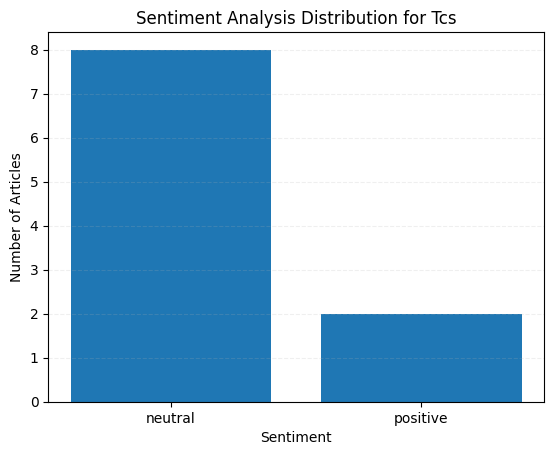

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Count sentiments
sentiment_labels = [item["sentiment"] for item in deep_sentiments]
sentiment_counts = Counter(sentiment_labels)

# Prepare data
labels = list(sentiment_counts.keys())
values = list(sentiment_counts.values())

# Plot bar chart
plt.figure()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.bar(labels, values)
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.title(f"Sentiment Analysis Distribution for {company_name}")
plt.show()




## 📈 Sentiment Polarity Trend

This visualization shows how sentiment polarity changes across a sequence of analyzed articles.

### Purpose
To represent the direction and strength of sentiments over time using a continuous trend.

### Method
- Positive sentiments are plotted above zero.
- Negative sentiments are plotted below zero.
- Neutral sentiments remain at zero.
- Confidence scores determine the magnitude of polarity.

### Output
A line chart displaying sentiment polarity across the selected articles.


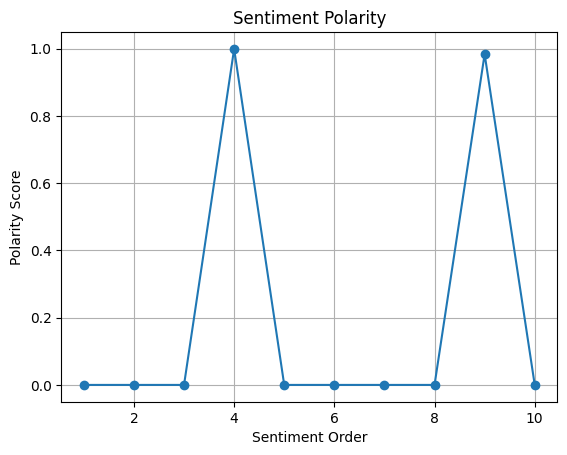

In [13]:
import matplotlib.pyplot as plt

def plot_sentiment_polarity(deep_sentiments, max_points=10):
    """
    Plots a line chart of sentiment polarity.
    Positive -> above 0
    Negative -> below 0
    Neutral  -> on 0
    """

    # Limit to first 10 sentiments
    sentiments = deep_sentiments[:max_points]

    x_values = list(range(1, len(sentiments) + 1))
    y_values = []

    for item in sentiments:
        sentiment = item["sentiment"].lower()
        confidence = item["confidence"]

        if sentiment == "positive":
            y_values.append(confidence)
        elif sentiment == "negative":
            y_values.append(-confidence)
        else:  # neutral
            y_values.append(0)

    # Plot
    plt.figure()
    plt.plot(x_values, y_values, marker='o')

    plt.xlabel("Sentiment Order")
    plt.ylabel("Polarity Score")
    plt.title("Sentiment Polarity")

    plt.grid(True)
    plt.show()

plot_sentiment_polarity(deep_sentiments)


### Closing Price Trend (Last 30 Days)

Plots the company's closing prices over the last 30 days. Dates are formatted as "MM-DD" for readability. To reduce clutter, only every 3rd date is shown on the x-axis.


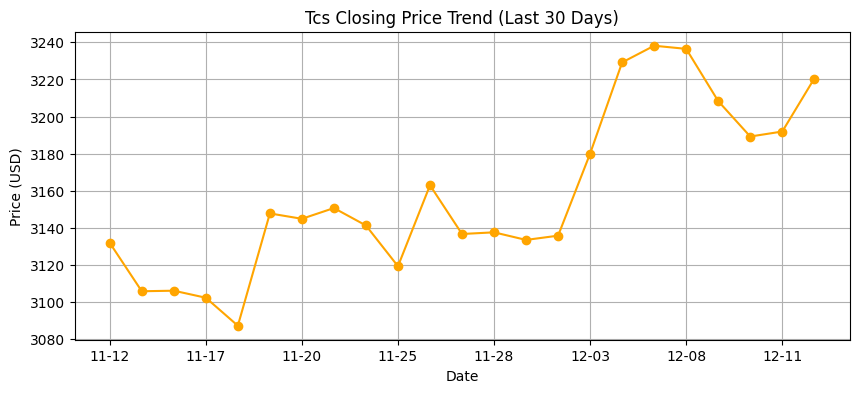

In [14]:
# Convert the dates to "Month-Day" format
market_df["Date_str"] = market_df["Date"].dt.strftime('%m-%d')
plt.figure(figsize=(10,4))
plt.plot(market_df["Date_str"], market_df["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)

N = 3  # fewer labels
plt.xticks(ticks=range(0, len(market_df), N), labels=market_df["Date_str"][::N])
plt.show()


## Using Alpha Vantage for Stock Data


First, install the library:

In [15]:
!pip install alpha_vantage

### 📈 Stock & Crypto Trend Analysis (Alpha Vantage)

This cell fetches daily market data using the Alpha Vantage API, automatically detects stock or crypto symbols from company names, and analyzes market trends using 20-day and 50-day Simple Moving Averages (SMA). It then classifies the asset as **Bullish**, **Bearish**, or **Sideways** based on SMA crossover logic.


In [16]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API')
def detect_symbol(company_name: str) -> str:
    """
    Maps common company/asset names to their typical stock or crypto symbols.
    If no match is found, the name itself is returned as the potential symbol.
    """
    mapping = {
    "BITCOIN": "BTCUSD",
    "BTC": "BTCUSD",
    "TESLA": "TSLA",
    "TSLA": "TSLA",
    "NETFLIX": "NFLX",
    "NFLX": "NFLX",
    "INFOSYS": "INFY",
    "INFY": "INFY",
    "TCS": "TCS",
    "TATA CONSULTANCY": "TCS",
    "RAKUTEN": "RKUNY",
    "APPLE": "AAPL",
    "AAPL": "AAPL",
    "GOOGLE": "GOOG",
    "ALPHABET": "GOOG",
    "GOOG": "GOOG",
    "MICROSOFT": "MSFT",
    "MSFT": "MSFT",
    "AMAZON": "AMZN",
    "AMZN": "AMZN",
    "NVIDIA": "NVDA",
    "NVDA": "NVDA",
    "META": "META",
    "FACEBOOK": "META",
    "AMD": "AMD",
    "INTEL": "INTC",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "RELIANCE": "RELIANCE.BSE",
    "HDFC": "HDFC.BSE",
    "ICICI": "ICICIBANK.BSE",
    "WIPRO": "WIPRO.BSE",
    "HCL": "HCLTECH.BSE",
    "ETHEREUM": "ETHUSD",
    "ETH": "ETHUSD",
    "DOGE": "DOGEUSD",
    "DOGECOIN": "DOGEUSD",
    "SOLANA": "SOLUSD",
    "SOL": "SOLUSD",
}

    return mapping.get(company_name.upper(), company_name.upper())

    # --- Core Trend Analysis Logic ---
def get_trend(df: pd.DataFrame) -> tuple[str, str]:
    """
    Calculates 20-day and 50-day Simple Moving Averages (SMA) to determine
    the market trend (Bullish, Bearish, or Sideways).
    The '4. close' column is used for calculations.
    """
    df = df.copy()

    # Check for minimum data requirement for a reliable 50-day SMA
    if len(df) < 50:
        return "⚠️ Insufficient Data", "Cannot calculate trend (needs at least 50 days of data)"

    # Calculate SMAs
    df['SMA20'] = df['4. close'].rolling(window=20).mean()
    df['SMA50'] = df['4. close'].rolling(window=50).mean()

    latest = df.iloc[-1]

    # Handle potential NaN values (occurs if the window is not yet full)
    if pd.isna(latest['SMA20']) or pd.isna(latest['SMA50']):
         return "⚠️ Data Not Yet Complete", "Need more data points for rolling average calculation"

    # Compare SMAs (Golden Cross / Death Cross strategy)
    if latest['SMA20'] > latest['SMA50']:
        return "✅ Bullish Trend", "The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend."
    elif latest['SMA20'] < latest['SMA50']:
        return "❌ Bearish Trend", "The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend."
    else:
        return "↔️ Sideways Market", "SMAs are crossing or are too close. Neutral — Wait for a breakout."

# --- Main Execution Block ---
def run_analysis():
    """
    Main function to ask for user input, fetch data, and print the analysis.
    """
    if not API_KEY:
        print("\n❌ Error: ALPHA_VANTAGE_API_KEY is not configured.")
        print("Please set the 'ALPHA_VANTAGE_API_KEY' secret in your environment.")
        return

    if not company_name:
        print("Analysis cancelled: Company name cannot be empty.")
        return

    print(f"\nData analysis will be performed for: {company_name}")

    # --- SYMBOL DETECTION ---
    global symbol
    symbol = detect_symbol(company_name)
    print(f"Using symbol: {symbol}")

    # --- FETCH & PROCESS ---
    try:
        # Initialize the TimeSeries client
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        global data
        # Fetch daily data (compact size fetches 100 data points, good for 50-day SMA)
        data, meta = ts.get_daily(symbol=symbol, outputsize='compact')
        # Alpha Vantage returns data newest-first, so sort the index (date) oldest-first
        data = data.sort_index()
        # print(data)

        print(f"\n📊 Latest Market Data for {company_name} ({symbol}):")
        # Display the last 3 days of data for review
        print(data[['4. close']].tail(3).to_markdown(numalign="left", stralign="left"))
        global trend, decision
        # Perform the trend analysis
        trend, decision = get_trend(data)

        # Output the results
        print("\n--- Analysis Result ---")
        print(f"Asset: {company_name} ({symbol})")
        print(f"📌 Trend Status: {trend}")
        print(f"🧾 Decision: {decision}")
        print("-----------------------")

    except ValueError as ve:
        # Alpha Vantage throws ValueError on invalid symbol or API key issues
        print(f"\n❌ Error fetching data for {company_name} ({symbol}):")
        print(f"    Details: {ve}")
        print("    Suggestion: Check if the symbol is correct and if the API key is valid.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == "__main__":
    run_analysis()


Data analysis will be performed for: Tcs
Using symbol: TCS

📊 Latest Market Data for Tcs (TCS):
| date                | 4. close   |
|:--------------------|:-----------|
| 2025-02-20 00:00:00 | 0.1405     |
| 2025-02-21 00:00:00 | 0.1405     |
| 2025-02-24 00:00:00 | 0.1405     |

--- Analysis Result ---
Asset: Tcs (TCS)
📌 Trend Status: ❌ Bearish Trend
🧾 Decision: The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend.
-----------------------


Now, let's visualize the closing price over time:



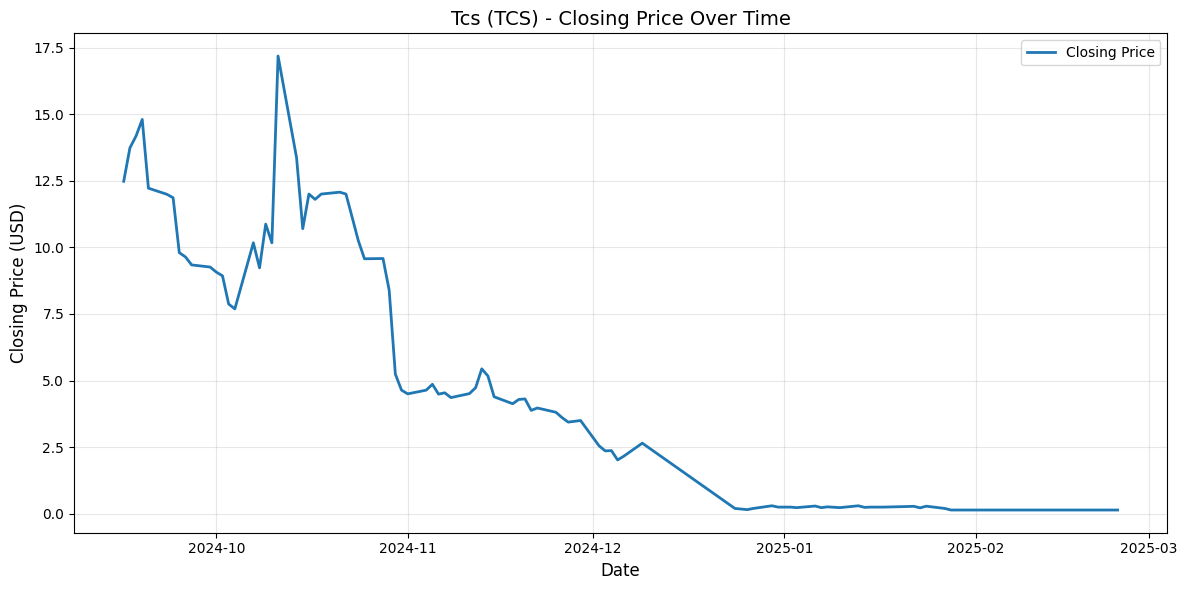

In [17]:
# Ensure data exists
if 'data' in locals() and hasattr(data, "empty") and not data.empty:

    # Ensure index is datetime for proper plotting
    if not isinstance(data.index, type(pd.to_datetime([]))):
        data.index = pd.to_datetime(data.index, errors='coerce')

    # Sort by date just in case
    data = data.sort_index()

    # Ensure required column exists
    if '4. close' in data.columns:

        # Drop NaN values to avoid broken lines
        plot_data = data['4. close'].dropna()

        plt.figure(figsize=(12,6))
        plt.plot(plot_data.index, plot_data, label='Closing Price', linewidth=2)

        plt.title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Closing Price (USD)", fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("Column '4. close' not found in data.")
else:
    print("No data available to visualize. Please run the data fetch cell first.")


In [18]:
import plotly.graph_objects as go

# Ensure data is available
if 'data' in locals() and hasattr(data, "empty") and not data.empty:

    # Ensure index is datetime
    if not isinstance(data.index, type(pd.to_datetime([]))):
        data.index = pd.to_datetime(data.index, errors='coerce')

    # Sort by date
    data = data.sort_index()

    # Required candlestick columns
    required_cols = ['1. open', '2. high', '3. low', '4. close']

    if all(col in data.columns for col in required_cols):

        # Drop rows with missing price data
        clean_data = data[required_cols].dropna()

        fig = go.Figure(data=[
            go.Candlestick(
                x=clean_data.index,
                open=clean_data['1. open'],
                high=clean_data['2. high'],
                low=clean_data['3. low'],
                close=clean_data['4. close'],
                name=f"{company_name}"
            )
        ])

        fig.update_layout(
            title=f"{company_name} ({symbol}) - Candlestick Chart",
            xaxis_title="Date",
            yaxis_title="Price (USD)",
            xaxis_rangeslider_visible=False,
            template="plotly_white",
            width=950,
            height=550
        )

        fig.show()

    else:
        print("One or more required OHLC columns are missing from the data.")
else:
    print("No data available to visualize. Please run the data fetch cell first.")


# Sprint 1 Conclusion
**What we achieved in Sprint 1:**

1. Collected real-time open-source data from:


* Wikipedia (summary)
* Yahoo Finance (market prices)
* Google News RSS (recent headlines)
* Generated synthetic tweets (50) for sentiment analysis

2. Cleaned and structured data using **pandas DataFrames**
3. Performed sentiment analysis using **TextBlob**

4. Visualized key insights:
* Sentiment distribution (bar chart)
* Sentiment trend across tweets (line chart)
* Market price trend (line chart)

5. Built a flexible, interactive notebook for any asset/company input

This notebook sets the foundation for Sprint 2, where we will integrate real-time dashboards and AI-driven analytics.

# **Slack Alerts Sender**

In [19]:
# ✅ Slack Alert Sender

import os, json, requests
from datetime import datetime

# ✅ Store your real webhook here for local testing
# (In Colab use: os.environ["SLACK_WEBHOOK_URL"] = userdata.get("SLACK_WEBHOOK_URL"))
SLACK_WEBHOOK_URL = userdata.get("SLACK_WEBHOOK_URL")
def send_slack_alert(data):
    webhook = SLACK_WEBHOOK_URL
    if not webhook:
        print("❌ Slack webhook missing.")
        return

    # ✅ Slack requires at least a "text" field
    payload = {
        "text": f"🚨 {data['alert_type']} for {data['company_name']} ({data['company_ticker']})",
        "blocks": [
            {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": f"{data['alert_type']} — {data['company_ticker']}"
                }
            },
            {
                "type": "section",
                "fields": [
                    {"type": "mrkdwn", "text": f"*Company:*\n{data['company_name']}"},
                    {"type": "mrkdwn", "text": f"*Ticker:*\n{data['company_ticker']}"},
                    # {"type": "mrkdwn", "text": f"*Price:*\n${data['current_price']:.2f}"},
                    {"type": "mrkdwn", "text": f"*Sentiment:*\n{data['sentiment_score']:.2f}"},
                    # {"type": "mrkdwn", "text": f"*Daily Change:*\n{data['daily_change_percent']:.2f}%"},
                    {"type": "mrkdwn", "text": f"*Volatility:*\n{data['volatility_metric']}"},
                ]
            },
            {"type": "divider"},
            {
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*Recommendation:*\n{data['strategic_action']}"
                }
            },
            {
                "type": "context",
                "elements": [
                    {"type": "mrkdwn", "text": f"Signal Time: {data['signal_time']}"}
                ]
            }
        ]
    }

    r = requests.post(
        webhook,
        data=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )

    if r.status_code == 200:
        print("✅ Slack alert sent successfully!")
    else:
        print("❌ Slack Error:", r.text)
def build_alert(company, ticker, title, body, sentiment):
    return {
        "company_name": company,
        "company_ticker": ticker,
        "alert_type": title,
        "strategic_action": body,
        # "current_price": price,
        "sentiment_score": sentiment,
        # "daily_change_percent": change,
        # "daily_change_absolute": round(price * (change / 100), 2),
        "volatility_metric": "Medium",
        "signal_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }


In [20]:
# ================== FIXED SENTIMENT + SLACK ALERT LOGIC ==================

sent_df = pd.DataFrame(deep_sentiments)

# Normalize sentiment labels so they match
sent_df["sentiment"] = sent_df["sentiment"].str.lower()

# Percent ratios
pos_ratio = (sent_df["sentiment"] == "positive").mean()
neg_ratio = (sent_df["sentiment"] == "negative").mean()
neu_ratio = (sent_df["sentiment"] == "neutral").mean()

# Convert to %
pos_p = pos_ratio * 100
neg_p = neg_ratio * 100
neu_p = neu_ratio * 100

print(f"Sentiment Summary → Positive: {pos_p:.1f}% | Negative: {neg_p:.1f}% | Neutral: {neu_p:.1f}%")

# ------------- SLACK ALERT TRIGGER -------------
if pos_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📈 Bullish Sentiment Detected",
        body=f"{company_name} shows strong *positive* sentiment ({pos_p:.1f}%).",
        sentiment=float(pos_ratio)
    )
    send_slack_alert(alert)

elif neg_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📉 Bearish Sentiment Detected",
        body=f"{company_name} shows strong *negative* sentiment ({neg_p:.1f}%). "
             f"Consider risk management or hedging strategies.",
        sentiment=float(-neg_ratio)
    )
    send_slack_alert(alert)

else:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="⚖️ Market Sentiment Neutral",
        body=(
            f"{company_name} shows mixed sentiment.\n\n"
            f"Positive: {pos_p:.1f}% | Negative: {neg_p:.1f}% | Neutral: {neu_p:.1f}%\n\n"
            f"No strong directional trend detected."
        ),
        sentiment=0.0
    )
    send_slack_alert(alert)

print("🚀 Alert object stored → can be viewed on Dashboard Slack popup")


Sentiment Summary → Positive: 20.0% | Negative: 0.0% | Neutral: 80.0%
✅ Slack alert sent successfully!
🚀 Alert object stored → can be viewed on Dashboard Slack popup


In [21]:
# Sprint 3: Code Cell - Prophet Forecasting, Signal Generation, and Slack Alerts

!pip install -q prophet requests  # Install if needed

import yfinance as yf
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
from datetime import datetime
import requests
from typing import Dict, Any
from google.colab import userdata

def download_price_data(ticker: str, period: str = '2y') -> pd.DataFrame:
    """
    Download historical closing prices from Yahoo Finance.

    Args:
        ticker (str): Stock symbol.
        period (str): Data period (e.g., '2y').

    Returns:
        pd.DataFrame: DataFrame with 'ds' (date) and 'y' (close price) columns.

    Error Handling:
        - Falls back to mock data if download fails.
    """
    try:
        data = yf.download(ticker, period=period, progress=False)
        df = data[['Close']].reset_index()
        df.columns = ['ds', 'y']
        df['ds'] = pd.to_datetime(df['ds'])
        print(f"Downloaded {len(df)} days of {ticker} price data.")
        return df
    except Exception as e:
        print(f"Download error: {e}. Using mock data.")
        dates = pd.date_range(start='2023-12-01', periods=500, freq='D')
        mock_prices = 500 + np.cumsum(np.random.randn(500) * 5)
        return pd.DataFrame({'ds': dates, 'y': mock_prices})

def build_prophet_model(data: pd.DataFrame) -> Prophet:
    """
    Fit Prophet model with seasonality and validate via cross-validation.

    Args:
        data (pd.DataFrame): Input data with 'ds' and 'y'.

    Returns:
        Prophet: Fitted model object.
    """
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    model.add_country_holidays(country_name='US')  # Add US holidays
    model.fit(data)

    # Cross-validation for RMSE
    try:
        df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')
        df_perf = performance_metrics(df_cv)
        rmse = df_perf['rmse'].mean()
        print(f"Model fitted. Cross-validation RMSE: {rmse:.2f}")
    except Exception as e:
        print(f"Validation skipped: {e}")

    return model

def generate_7day_forecast(model: Prophet) -> pd.DataFrame:
    """
    Generate 7-day future forecast with confidence intervals.

    Args:
        model (Prophet): Fitted model.

    Returns:
        pd.DataFrame: Forecast DataFrame (ds, yhat, yhat_lower, yhat_upper).
    """
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    forecast_7d = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
    forecast_7d['ds'] = forecast_7d['ds'].dt.strftime('%Y-%m-%d')
    print("7-day forecast generated.")
    return forecast_7d

# Main Execution
print("=== SPRINT 3: FORECASTING & ALERTS ===\n")

# Step 1: Data
price_data = download_price_data(symbol)

# 🔥 If Yahoo returned 0 rows, try NSE fallback automatically
if price_data.shape[0] <= 1:
    if symbol.endswith(".BSE"):
        alt_symbol = symbol.replace(".BSE", ".NS")
        print(f"⚠ No BSE data found. Retrying with NSE ticker: {alt_symbol}")
        price_data = download_price_data(alt_symbol)
        symbol = alt_symbol   # Update global symbol
if price_data.shape[0] < 10:
    print("⚠ Not enough historical data. Using mock price sequence instead.")
    dates = pd.date_range(start='2023-01-01', periods=400, freq='D')
    mock_prices = 600 + np.cumsum(np.random.randn(400) * 4)
    price_data = pd.DataFrame({ 'ds': dates, 'y': mock_prices })

# Step 2: Model
prophet_model = build_prophet_model(price_data)

# Step 3: Forecast
forecast_df = generate_7day_forecast(prophet_model)


# Outputs
print("\n--- 7-DAY FORECAST TABLE ---")
print(forecast_df.round(2).to_string(index=False))


# Store for Sprint 4
%store price_data prophet_model forecast_df

=== SPRINT 3: FORECASTING & ALERTS ===



/tmp/ipython-input-1261963212.py:30: FutureWarning:

YF.download() has changed argument auto_adjust default to True

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TCS']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')


Downloaded 0 days of TCS price data.
⚠ Not enough historical data. Using mock price sequence instead.
Validation skipped: Less data than horizon after initial window. Make horizon or initial shorter.
7-day forecast generated.

--- 7-DAY FORECAST TABLE ---
        ds   yhat  yhat_lower  yhat_upper
2024-02-05 533.48      526.45      540.73
2024-02-06 533.77      526.53      540.97
2024-02-07 534.41      527.39      541.92
2024-02-08 534.78      527.58      541.90
2024-02-09 536.06      529.34      542.83
2024-02-10 536.63      529.75      543.55
2024-02-11 536.68      529.33      544.25
Stored 'price_data' (DataFrame)
Stored 'prophet_model' (Prophet)
Stored 'forecast_df' (DataFrame)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.



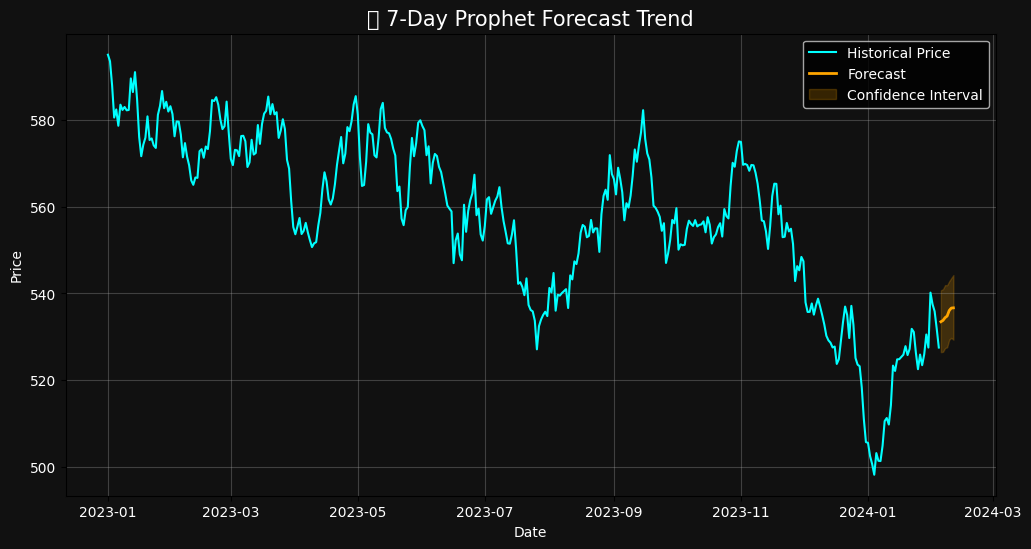

In [22]:
import matplotlib.pyplot as plt

# Ensure datetime values are parsed correctly
price_data['ds'] = pd.to_datetime(price_data['ds'])
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

plt.figure(figsize=(12, 6))

# 🔵 Historical closing prices
plt.plot(price_data['ds'], price_data['y'], label="Historical Price", color="cyan")

# 🔮 Prophet forecast
plt.plot(forecast_df['ds'], forecast_df['yhat'], label="Forecast", color="orange", linewidth=2)

# 🌫 Confidence Interval
plt.fill_between(
    forecast_df['ds'],
    forecast_df['yhat_lower'],
    forecast_df['yhat_upper'],
    alpha=0.2,
    color="orange",
    label="Confidence Interval"
)

plt.title("📌 7-Day Prophet Forecast Trend", fontsize=15, color="white")
plt.xlabel("Date", color="white")
plt.ylabel("Price", color="white")
plt.legend(facecolor="black", labelcolor="white")
plt.grid(alpha=0.3)

# Dark mode styling
plt.gca().set_facecolor("#111")
plt.gcf().patch.set_facecolor("#111")
plt.xticks(color="white")
plt.yticks(color="white")

plt.show()


=== SPRINT 3: FORECASTING & ALERTS ===

In [23]:
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [24]:
def card(title, content):
    html = f"""
    <div style='border:1px solid #ddd;border-radius:10px;padding:15px;margin:10px;
                background:beige;font-family:sans-serif;color:black;'>
        <h3 style='text-align:center; color:black'>{title}</h3>
        <p style='line-height:1.5; font-color:white;'>{content}</p>
    </div>
    """
    display(HTML(html))


In [ ]:
# ============================
# FINAL INTERACTIVE DASHBOARD
# ============================
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --------- GLOBAL STYLE (Dark + Gradient Buttons + Modal) ---------
dashboard_css = """
<style>
/* Page background */
body {
  background: #05060a;
  color: #f5f5f5;
  font-family: "Segoe UI", system-ui, sans-serif;
}

/* Main wrapper */
#rtis-root {
  max-width: 1150px;
  margin: 0 auto 40px auto;
}

/* Title area */
.rtis-hero {
  background: radial-gradient(circle at top left, #1f4fff 0, #050816 45%);
  border-radius: 18px;
  padding: 18px 22px;
  margin-bottom: 16px;
  box-shadow: 0 0 40px rgba(0, 0, 0, 0.7);
  border: 1px solid rgba(0, 255, 255, 0.12);
}
.rtis-title {
  font-size: 22px;
  font-weight: 700;
  letter-spacing: 0.5px;
  color: #e9f5ff;
}
.rtis-subtitle {
  font-size: 13px;
  color: #a9c7ff;
  margin-top: 4px;
}
.rtis-company {
  font-size: 14px;
  margin-top: 8px;
  color: #f5f5f5;
}

/* Buttons row container */
.rtis-btn-row {
  display: flex;
  gap: 10px;
  margin: 10px 0 4px 0;
  flex-wrap: wrap;
}

/* override ipywidgets button look to gradient glossy style */
button.widget-button {
  background-image: linear-gradient(135deg, #004cff, #00e5ff);
  border-radius: 999px !important;
  border: 1px solid rgba(0,0,0,0.5) !important;
  color: #fff !important;
  font-weight: 600 !important;
  font-size: 13px !important;
  padding: 6px 16px !important;
  box-shadow: 0 6px 16px rgba(0,0,0,0.45);
  transition: transform 0.1s ease, box-shadow 0.1s ease, filter 0.1s ease;
}
button.widget-button:hover {
  transform: translateY(-1px);
  box-shadow: 0 10px 24px rgba(0,0,0,0.6);
  filter: brightness(1.06);
}
button.widget-button:focus {
  outline: none !important;
  box-shadow: 0 0 0 2px rgba(0,229,255,0.6);
}

/* Right content card */
.rtis-panel {
  background: rgba(10, 12, 20, 0.95);
  border-radius: 16px;
  border: 1px solid rgba(255,255,255,0.06);
  padding: 14px 18px;
  box-shadow: 0 0 30px rgba(0,0,0,0.7);
  margin-top: 10px;
}

/* Slack modal */
#slackModalOverlay {
  display: none;
  position: fixed;
  z-index: 9999;
  left: 0; top: 0;
  width: 100%; height: 100%;
  background: rgba(0,0,0,0.7);
}
#slackModal {
  position: absolute;
  top: 50%; left: 50%;
  transform: translate(-50%, -50%);
  background: #050812;
  border-radius: 16px;
  width: 420px;
  max-width: 92%;
  padding: 18px 20px;
  box-shadow: 0 0 40px rgba(0,0,0,0.9);
  border: 1px solid rgba(0, 229, 255, 0.4);
  color: #f5f5f5;
}
#slackModal h3 {
  margin-top: 0;
  margin-bottom: 8px;
  font-size: 18px;
  color: #00e5ff;
}
#slackModal p {
  font-size: 13px;
  line-height: 1.5;
}
#slackModalClose {
  float: right;
  cursor: pointer;
  color: #aaa;
}
#slackModalClose:hover {
  color: #fff;
}

/* small metric chips */
.rtis-chip-row {
  display: flex;
  gap: 6px;
  flex-wrap: wrap;
  margin-top: 8px;
}
.rtis-chip {
  font-size: 11px;
  padding: 4px 10px;
  border-radius: 999px;
  background: rgba(255,255,255,0.06);
  border: 1px solid rgba(255,255,255,0.08);
}

/* Forecast & sentiment headings */
.rtis-section-title {
  font-size: 15px;
  font-weight: 600;
  color: #b9e6ff;
  margin-bottom: 4px;
}
</style>

<div id="rtis-root">
  <div class="rtis-hero">
    <div class="rtis-title">Real-Time Industry Insight & Strategic Intelligence System</div>
    <div class="rtis-subtitle">
      Live market data · LLM-powered news sentiment · Prophet-based forecasting · Slack risk alerts
    </div>
    <div class="rtis-company">
      📌 Active Asset: <b id="rtis-company-slot"></b>
    </div>
  </div>
</div>

<!-- Slack Modal -->
<div id="slackModalOverlay">
  <div id="slackModal">
    <span id="slackModalClose">✕</span>
    <h3>🔔 Last Slack Alert</h3>
    <div id="slackModalBody">
      <!-- Filled from Python -->
    </div>
  </div>
</div>

<script>
function openSlackModal() {
  document.getElementById('slackModalOverlay').style.display = 'block';
}
function closeSlackModal() {
  document.getElementById('slackModalOverlay').style.display = 'none';
}
document.getElementById('slackModalClose').onclick = closeSlackModal;
document.getElementById('slackModalOverlay').onclick = function(e) {
  if (e.target.id === 'slackModalOverlay') closeSlackModal();
};
</script>
"""
display(HTML(dashboard_css))

# inject current company_name into hero
try:
    display(HTML(f"""
    <script>
      document.getElementById('rtis-company-slot').innerText = "{company_name}";
    </script>
    """))
except NameError:
    company_name = "Unknown"
    display(HTML("""
    <script>
      document.getElementById('rtis-company-slot').innerText = "Unknown";
    </script>
    """))

# --------- BACKGROUND ANIMATED PRICE GRAPH (Plotly) ---------
try:
    if 'market_df' in globals() and not market_df.empty:
        bg_df = market_df.tail(60).copy()
        bg_df = bg_df.sort_values("Date")
        fig_bg = px.line(
        bg_df, x="Date", y="Close",
        template="plotly_dark",
        )
        fig_bg.update_layout(
        height=320,
        margin=dict(l=10, r=10, t=30, b=10),
        showlegend=False,
        title=f"{company_name} – Recent Price Motion"
          )
        fig_bg.update_traces(line=dict(width=3, color="#00e5ff"))
        fig_bg.show()

    else:
        print("⚠️ market_df is empty or not defined – background graph skipped.")
except Exception as e:
    print("⚠️ Could not render animated background graph:", e)

# --------- MAIN LAYOUT WIDGETS ---------
right_output = widgets.Output()

# Buttons row (gradient via CSS)
btn_overview   = widgets.Button(description="🏠 Overview",      layout=widgets.Layout(width="140px"))
btn_forecast   = widgets.Button(description="📊 Forecast",      layout=widgets.Layout(width="140px"))
btn_sentiment  = widgets.Button(description="💬 Sentiment",     layout=widgets.Layout(width="140px"))
btn_news       = widgets.Button(description="📰 News",          layout=widgets.Layout(width="140px"))
btn_slack_card = widgets.Button(description="🔔 Slack Alert",   layout=widgets.Layout(width="140px"))
# NEW BUTTON — Send Slack Alert
btn_send_slack = widgets.Button(
    description="🚨 Trigger Slack Alert",
    layout=widgets.Layout(width="160px")
)

# Place buttons in one row
btn_row = widgets.HBox([
    btn_overview, btn_forecast, btn_sentiment, btn_news,
    btn_slack_card, btn_send_slack
])

display(HTML("<div class='rtis-btn-row'></div>"))
display(btn_row)
display(widgets.HTML("<div class='rtis-panel'></div>"))
display(right_output)

# --------- HELPER: SHORT SUMMARY TEXT ---------
short_summary = ""
if "wiki_summary" in globals() and isinstance(wiki_summary, str):
  parts = wiki_summary.split(". ")
  short_summary = ". ".join(parts[:2]) + "..."
else:
    short_summary = f"{company_name} is an actively tracked asset in this system, combining price action, LLM-based sentiment, and forecasting."
    # ---- Extra Graph 1: Latest 30-day closing trend ----
fig2 = go.Figure()
last30 = market_df.tail(30)
fig2.add_trace(go.Scatter(
    x=last30["Date"], y=last30["Close"],
    mode="lines+markers",
    line=dict(color="#00e5ff", width=2),
    name="30-Day Close"
))
fig2.update_layout(
    title=f"{company_name} – Last 30-Days Price Trend",
    template="plotly_dark", height=320,
    margin=dict(l=10, r=10, t=40, b=10)
)

# ---- Extra Graph 2: Candlestick ----
fig3 = go.Figure(data=[
    go.Candlestick(
        x=last30["Date"],
        open=last30["Open"],
        high=last30["High"],
        low=last30["Low"],
        close=last30["Close"]
    )
])
fig3.update_layout(
    title=f"{company_name} – Candlestick Overview",
    xaxis_rangeslider_visible=False,
    template="plotly_dark", height=320,
    margin=dict(l=10, r=10, t=40, b=10)
)

display(fig2)
display(fig3)


# --------- VIEW FUNCTIONS ---------
def view_overview(_=None):
    with right_output:
        clear_output()
        html = f"""
        <div class="rtis-panel">
          <div class="rtis-section-title">Company Overview</div>
          <p style="font-size:13px; line-height:1.5; color:#e0ecff;">
            {short_summary}
          </p>
          <div class="rtis-chip-row">
            <span class="rtis-chip">✔ Live Market Data</span>
            <span class="rtis-chip">✔ FinBERT/LLM Sentiment</span>
            <span class="rtis-chip">✔ Prophet Forecast (7-Day)</span>
            <span class="rtis-chip">✔ Slack Risk Alerts</span>
          </div>
          <hr style="border-color:#222; margin:10px 0;">
          <p style="font-size:12px; color:#9fb4d9;">
            This dashboard continuously blends <b>market structure</b> (trend, volatility),
            <b>news flow</b> (Google News RSS), and <b>LLM-based sentiment</b> to support
            data-driven decisions for {company_name}.
          </p>
        </div>
        """
        display(HTML(html))


def view_forecast(_=None):
    with right_output:
        clear_output()
        if "price_data" not in globals() or "forecast_df" not in globals():
            display(HTML("<div class='rtis-panel'><p>⚠️ Prophet forecast data not available. Please run Prophet cell first.</p></div>"))
            return

        # ensure datetime
        local_price = price_data.copy()
        local_forecast = forecast_df.copy()
        local_price["ds"] = pd.to_datetime(local_price["ds"])
        local_forecast["ds"] = pd.to_datetime(local_forecast["ds"])

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=local_price["ds"],
            y=local_price["y"],
            mode="lines",
            name="Historical Price",
            line=dict(color="#00e5ff", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=local_forecast["ds"],
            y=local_forecast["yhat"],
            mode="lines+markers",
            name="Forecast (7d)",
            line=dict(color="#ffb347", width=2)
        ))
        fig.add_trace(go.Scatter(
            x=local_forecast["ds"],
            y=local_forecast["yhat_upper"],
            mode="lines",
            name="Upper Band",
            line=dict(color="rgba(255,179,71,0.3)", width=1, dash="dot"),
            showlegend=False
        ))
        fig.add_trace(go.Scatter(
            x=local_forecast["ds"],
            y=local_forecast["yhat_lower"],
            mode="lines",
            name="Lower Band",
            line=dict(color="rgba(255,179,71,0.3)", width=1, dash="dot"),
            fill='tonexty',
            fillcolor="rgba(255,179,71,0.1)",
            showlegend=False
        ))

        fig.update_layout(
            template="plotly_dark",
            height=420,
            margin=dict(l=10, r=10, t=40, b=10),
            title=f"{company_name} — 7-Day Prophet Forecast",
            xaxis_title="Date",
            yaxis_title="Price",
        )

        display(HTML("<div class='rtis-panel'>"))
        fig.show()
        display(HTML("</div>"))


def view_sentiment(_=None):
    with right_output:
        clear_output()
        if "deep_sentiments" not in globals() or not deep_sentiments:
            display(HTML("<div class='rtis-panel'><p>⚠️ No sentiment data found. Run FinBERT sentiment cell first.</p></div>"))
            return

        s_df = pd.DataFrame(deep_sentiments)
        # normalize label casing
        s_df["sentiment"] = s_df["sentiment"].str.capitalize()

        counts = s_df["sentiment"].value_counts()
        fig, ax = plt.subplots(figsize=(5.5,3.3))
        plt.style.use("dark_background")
        sns.barplot(
            x=counts.index,
            y=counts.values,
            palette=["#ff4c61", "#f5d742", "#00e676"],
            ax=ax
        )
        ax.set_title(f"Sentiment Distribution — {company_name}", color="#00eaff")
        ax.set_xlabel("Sentiment", color="white")
        ax.set_ylabel("Count", color="white")
        ax.tick_params(colors="white")
        ax.grid(alpha=0.2)

        # polarity line
        xs = list(range(1, min(11, len(s_df))+1))
        ys = []
        for i, row in s_df.head(10).iterrows():
            sent = row["sentiment"].lower()
            conf = float(row.get("confidence", 0.6))
            if sent == "positive":
                ys.append(conf)
            elif sent == "negative":
                ys.append(-conf)
            else:
                ys.append(0.0)

        fig2, ax2 = plt.subplots(figsize=(5.5,3.0))
        plt.style.use("dark_background")
        ax2.plot(xs, ys, marker="o", color="#00e5ff")
        ax2.axhline(0, color="#555", linestyle="--", linewidth=1)
        ax2.set_title("Sentiment Polarity (Top 10 News)", color="#00eaff")
        ax2.set_xlabel("Article Index", color="white")
        ax2.set_ylabel("Polarity", color="white")
        ax2.tick_params(colors="white")
        ax2.grid(alpha=0.2)

        display(HTML("<div class='rtis-panel'>"))
        display(fig)
        display(fig2)
        plt.close(fig)
        plt.close(fig2)
        display(HTML("</div>"))


def view_news(_=None):
    with right_output:
        clear_output()
        html_items = ""
        if "news_articles_with_links" in globals() and news_articles_with_links:
            for i, art in enumerate(news_articles_with_links, 1):
                html_items += f"""
                <div style='margin-bottom:8px;'>
                  <b style='color:#7adfff;'>{i}.</b>
                  <a href="{art['link']}" target="_blank" style='color:#e6f3ff; text-decoration:none;'>
                    {art['title']}
                  </a>
                </div>
                """
        else:
            html_items = "<p>⚠️ No news articles available. Try rerunning the news-fetch cell.</p>"

        html = f"""
        <div class='rtis-panel'>
          <div class='rtis-section-title'>Latest Headlines for {company_name}</div>
          <p style="font-size:12px; color:#9fb4d9;">
            Fetched via Google News RSS and used as primary input for FinBERT sentiment analysis.
          </p>
          {html_items}
        </div>
        """
        display(HTML(html))


def view_slack(_=None):
    """
    Fills the modal with last alert data and opens the popup.
    """
    if "alert" not in globals():
        body_html = "<p>⚠️ No Slack alert object named <code>alert</code> found. Run the alert generation cell first.</p>"
    else:
        a = alert
        body_html = f"""
        <p style="font-size:13px;">
          <b>Type:</b> {a.get('alert_type', 'N/A')}<br>
          <b>Company:</b> {a.get('company_name', 'N/A')} ({a.get('company_ticker', 'N/A')})<br>
          <b>Sentiment Score:</b> {a.get('sentiment_score', 'N/A')}<br>
          <b>Volatility:</b> {a.get('volatility_metric', 'N/A')}<br>
          <b>Signal Time:</b> {a.get('signal_time', 'N/A')}
        </p>
        <p style="font-size:13px; margin-top:6px;">
          <b>Recommendation:</b><br>
          {a.get('strategic_action', '')}
        </p>
        <p style="font-size:11px; color:#9fb4d9; margin-top:6px;">
          This is the same payload sent to Slack via the Incoming Webhook integration.
        </p>
        """

    js = f"""
    <script>
      document.getElementById('slackModalBody').innerHTML = `{body_html}`;
      openSlackModal();
    </script>
    """
    display(HTML(js))


# 🚨 NEW FUNCTION — Trigger Slack & Show Modal
def send_slack_and_show(_=None):
    global alert

    if "alert" not in globals():
        with right_output:
            clear_output()
            display(HTML("<div class='rtis-panel'><p>⚠️ No alert object generated yet from sentiment analysis.</p></div>"))
        return

    # Send Slack alert
    try:
        webhook = userdata.get("SLACK_WEBHOOK_URL")
        if webhook:
            import json, requests
            payload = {"text": alert["alert_type"], **alert}
            r = requests.post(webhook, json=payload)
            print("Slack Response:", r.status_code)
    except Exception as e:
        print("Slack Error:", e)

    # Immediately open popup to show the alert
    view_slack()



# --------- HOOK BUTTONS ---------
btn_overview.on_click(view_overview)
btn_forecast.on_click(view_forecast)
btn_sentiment.on_click(view_sentiment)
btn_news.on_click(view_news)
btn_slack_card.on_click(view_slack)
btn_send_slack.on_click(send_slack_and_show)




# Show default view
view_overview()
